In [1]:
import gzip
import json
import warnings
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
#from sklearn.preprocessing import OneHotEncoder
import timeit

In [2]:
#read the dataset
file_path_penguins ="penguins.csv"
data_set_penguins = pd.read_csv(file_path_penguins)
print(data_set_penguins.head())

  species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7                181   
1  Adelie  Torgersen              39.5             17.4                186   
2  Adelie  Torgersen              40.3             18.0                195   
3  Adelie  Torgersen              36.7             19.3                193   
4  Adelie  Torgersen              39.3             20.6                190   

   body_mass_g     sex  
0         3750    MALE  
1         3800  FEMALE  
2         3250  FEMALE  
3         3450  FEMALE  
4         3650    MALE  


In [3]:
#convert island and sex to 1-hot vectors 
island_one_hot = pd.get_dummies(data_set_penguins['island'], prefix='island')
sex_one_hot = pd.get_dummies(data_set_penguins['sex'], prefix='sex')
one_hot_vector = pd.concat([data_set_penguins,island_one_hot, sex_one_hot], axis=1)
one_hot_vector = one_hot_vector.drop(['island', 'sex'], axis=1)
print(one_hot_vector.head())
one_hot_vector.to_csv('one_hot_penguins.csv', index=False)

  species  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
0  Adelie              39.1             18.7                181         3750   
1  Adelie              39.5             17.4                186         3800   
2  Adelie              40.3             18.0                195         3250   
3  Adelie              36.7             19.3                193         3450   
4  Adelie              39.3             20.6                190         3650   

   island_Biscoe  island_Dream  island_Torgersen  sex_FEMALE  sex_MALE  
0              0             0                 1           0         1  
1              0             0                 1           1         0  
2              0             0                 1           1         0  
3              0             0                 1           1         0  
4              0             0                 1           0         1  


In [4]:
# manual conversion using categorization
manual_cat = data_set_penguins
manual_cat['island'] = pd.Categorical(manual_cat['island']).codes
manual_cat['sex'] = pd.Categorical(manual_cat['sex']).codes
print(manual_cat.head())
manual_cat.to_csv('manual_cat_penguins.csv', index=False)

  species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie       2              39.1             18.7                181   
1  Adelie       2              39.5             17.4                186   
2  Adelie       2              40.3             18.0                195   
3  Adelie       2              36.7             19.3                193   
4  Adelie       2              39.3             20.6                190   

   body_mass_g  sex  
0         3750    1  
1         3800    0  
2         3250    0  
3         3450    0  
4         3650    1  


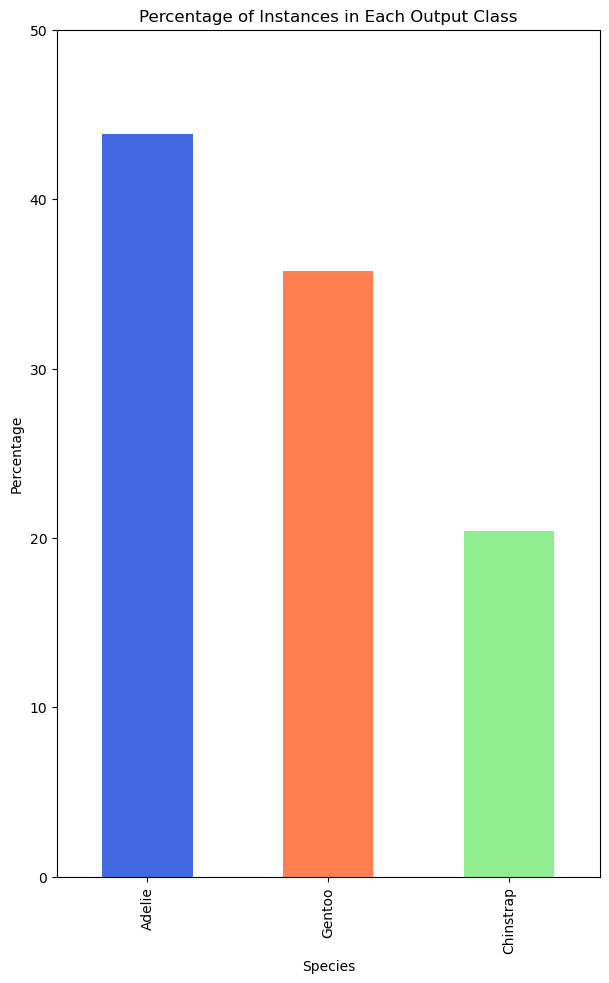

In [5]:
# plotting the % using one_hot_vector
plot = one_hot_vector
class_counts = plot['species'].value_counts()
class_percentages = (class_counts / len(plot)) * 100
colors = ['royalblue', 'coral', 'lightgreen']
plt.figure(figsize=(7, 11))
class_percentages.plot(kind='bar', color=colors)
plt.title('Percentage of Instances in Each Output Class')
plt.xlabel('Species')
plt.ylabel('Percentage')
plt.ylim(0, 50)
plt.savefig('penguin-classes.jpg')

In [6]:
split_set = one_hot_vector
X = split_set .drop('species', axis=1)
y = split_set ['species']
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("X_train shape:", X_train.shape) #number of samples, number of features
print("X_test shape:", X_test.shape)   #number of samples and features in the testing set
print("y_train shape:", y_train.shape) #one-dimensional array representing the number of samples
print("y_test shape:", y_test.shape)   #one-dimensional array representing the number of samples at the testing set

X_train shape: (249, 9)
X_test shape: (84, 9)
y_train shape: (249,)
y_test shape: (84,)


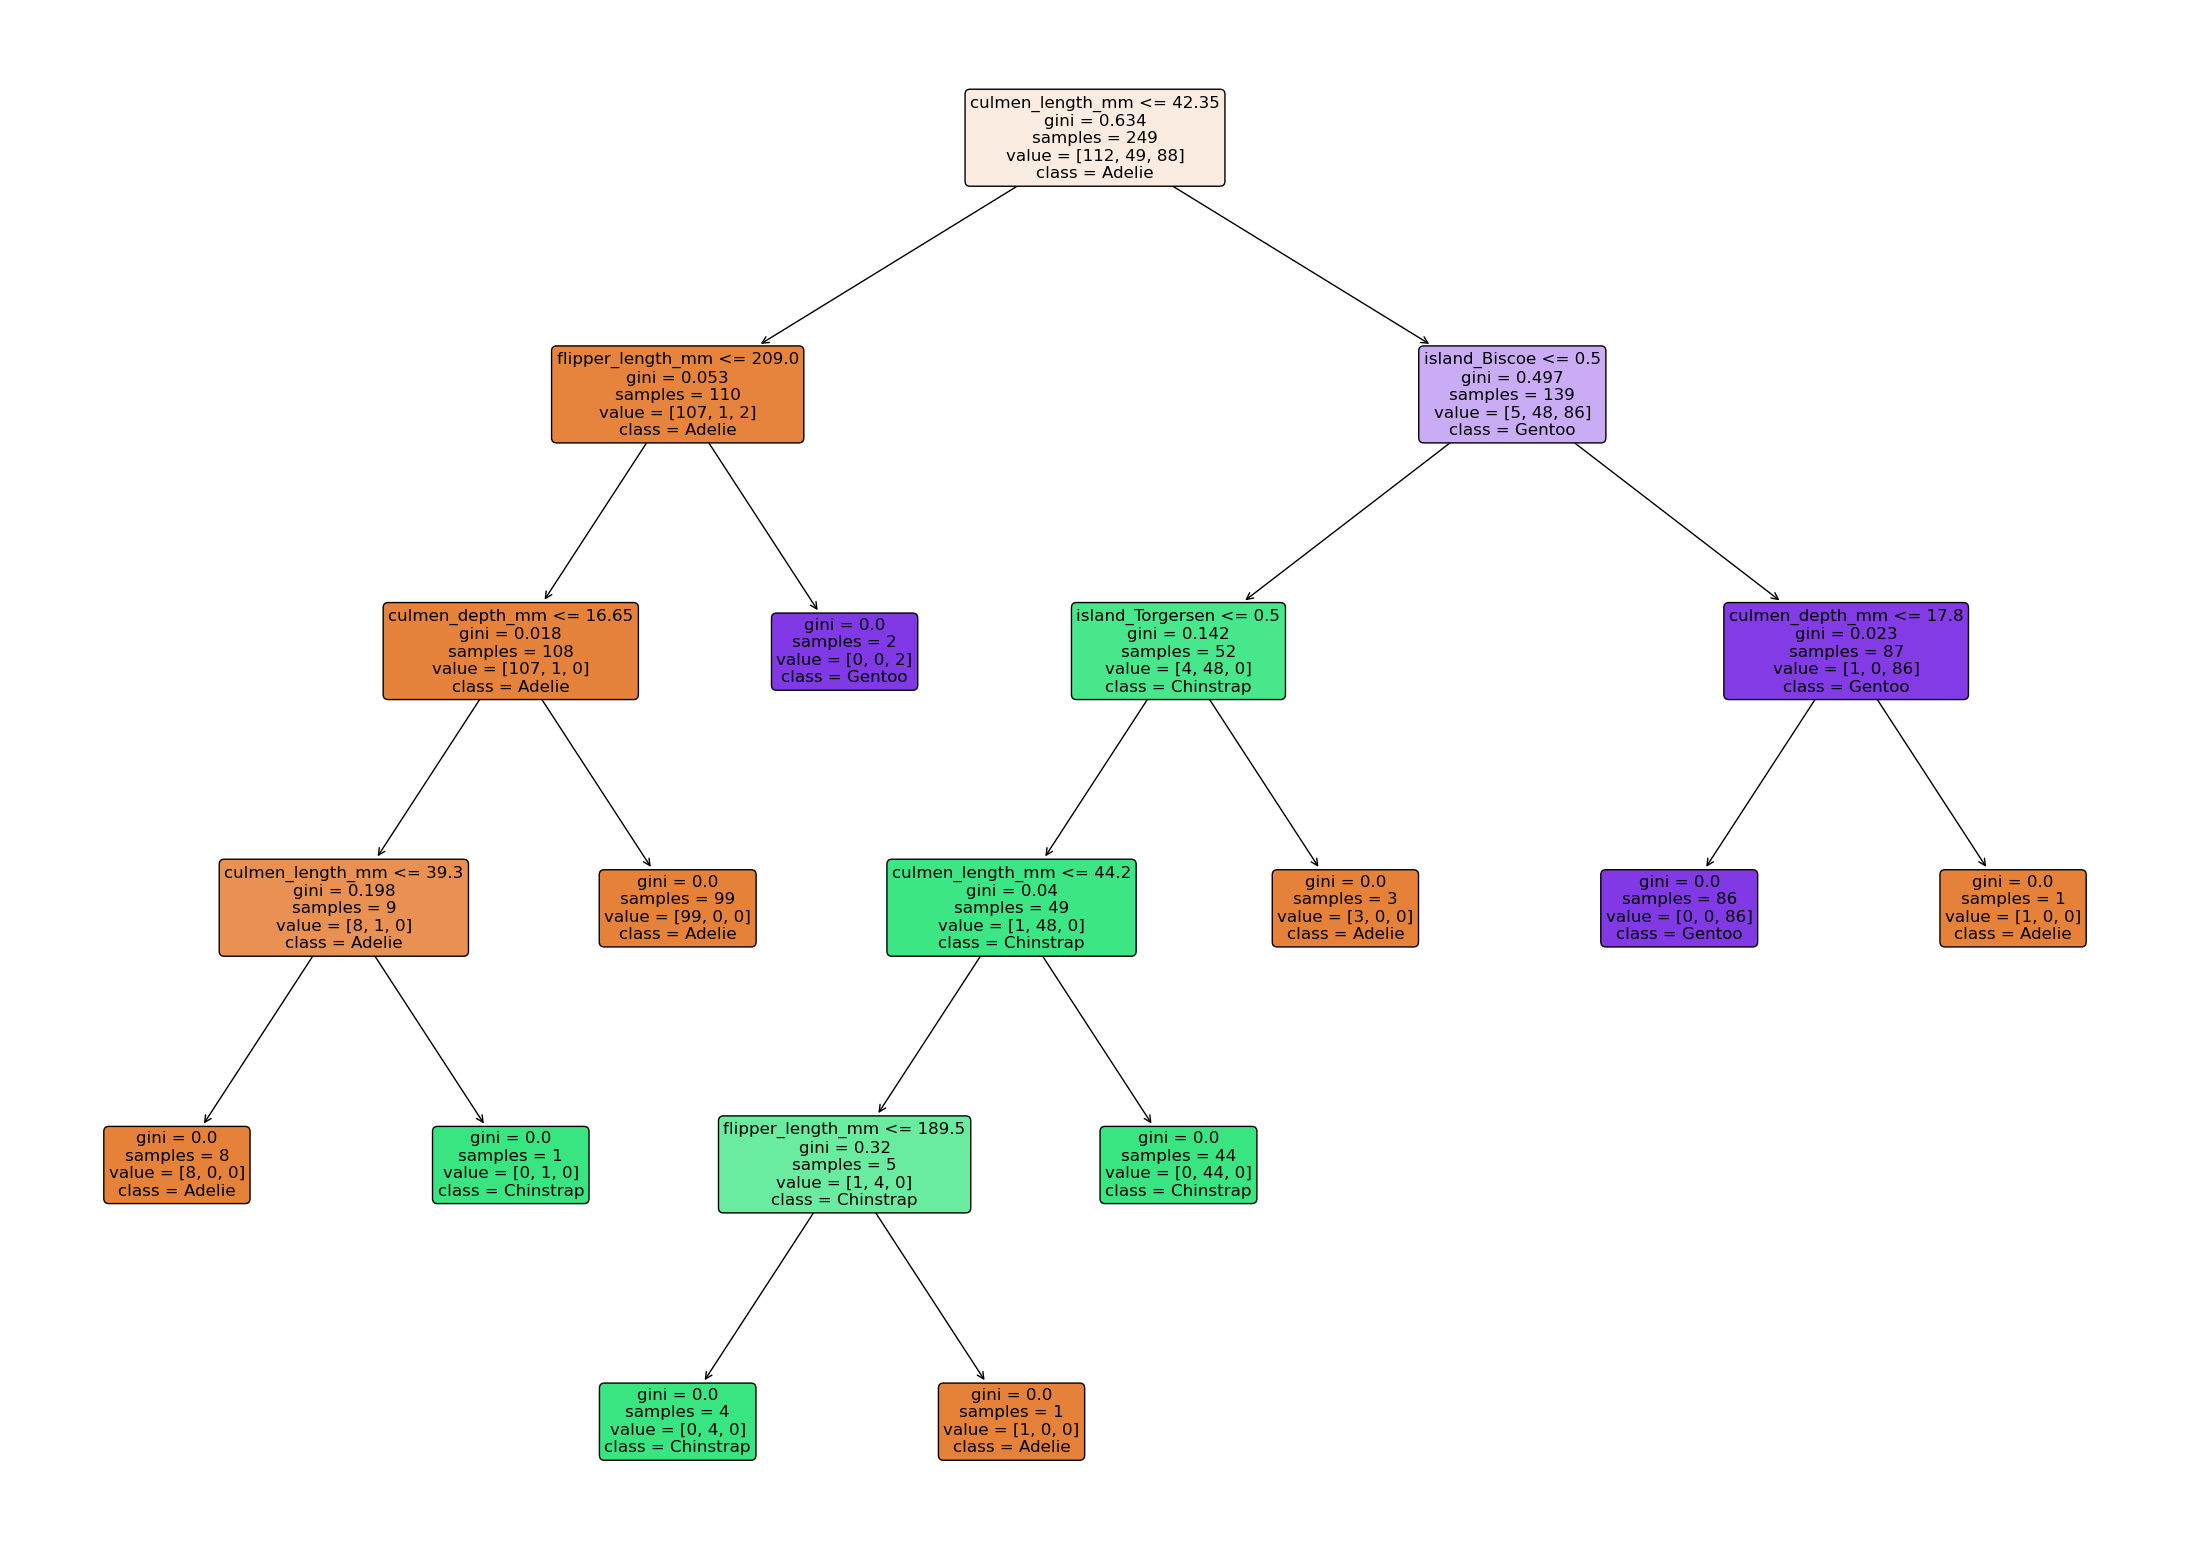

In [7]:
# Base-DT
base_dt_classifier = DecisionTreeClassifier()
base_dt_classifier.fit(X_train, y_train)
plt.figure(figsize=(28, 20))
plot_tree(base_dt_classifier, filled=True, feature_names=X.columns, class_names=y.unique(),fontsize=12 ,rounded=True)
plt.show()
y_pred = base_dt_classifier.predict(X_test)

# Append information to the performance file
with open('penguin-performance-Base-DT.txt', 'a') as file:
    file.write("A)Model: Decision Tree (Base-DT)\n")
    file.write("Hyperparameters: Default Parameters\n")
    file.write("-" * 50 + "\n")
    
    file.write("B)\n")
    file.write("Confusion Matrix:\n")
    file.write(str(confusion_matrix(y_test, y_pred)) + "\n\n")
    file.write("-" * 50 + "\n")
    
    file.write("C):\n")
    file.write(classification_report(y_test, y_pred) + "\n")
    file.write("-" * 50 + "\n")
    
    file.write("D):\n")
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    file.write("\nAccuracy: {:.4f}\n".format(accuracy))
    file.write("Macro-average F1: {:.4f}\n".format(macro_f1))
    file.write("Weighted-average F1: {:.4f}\n".format(weighted_f1))

    file.write("\n" + "*" * 70 + "\n\n")

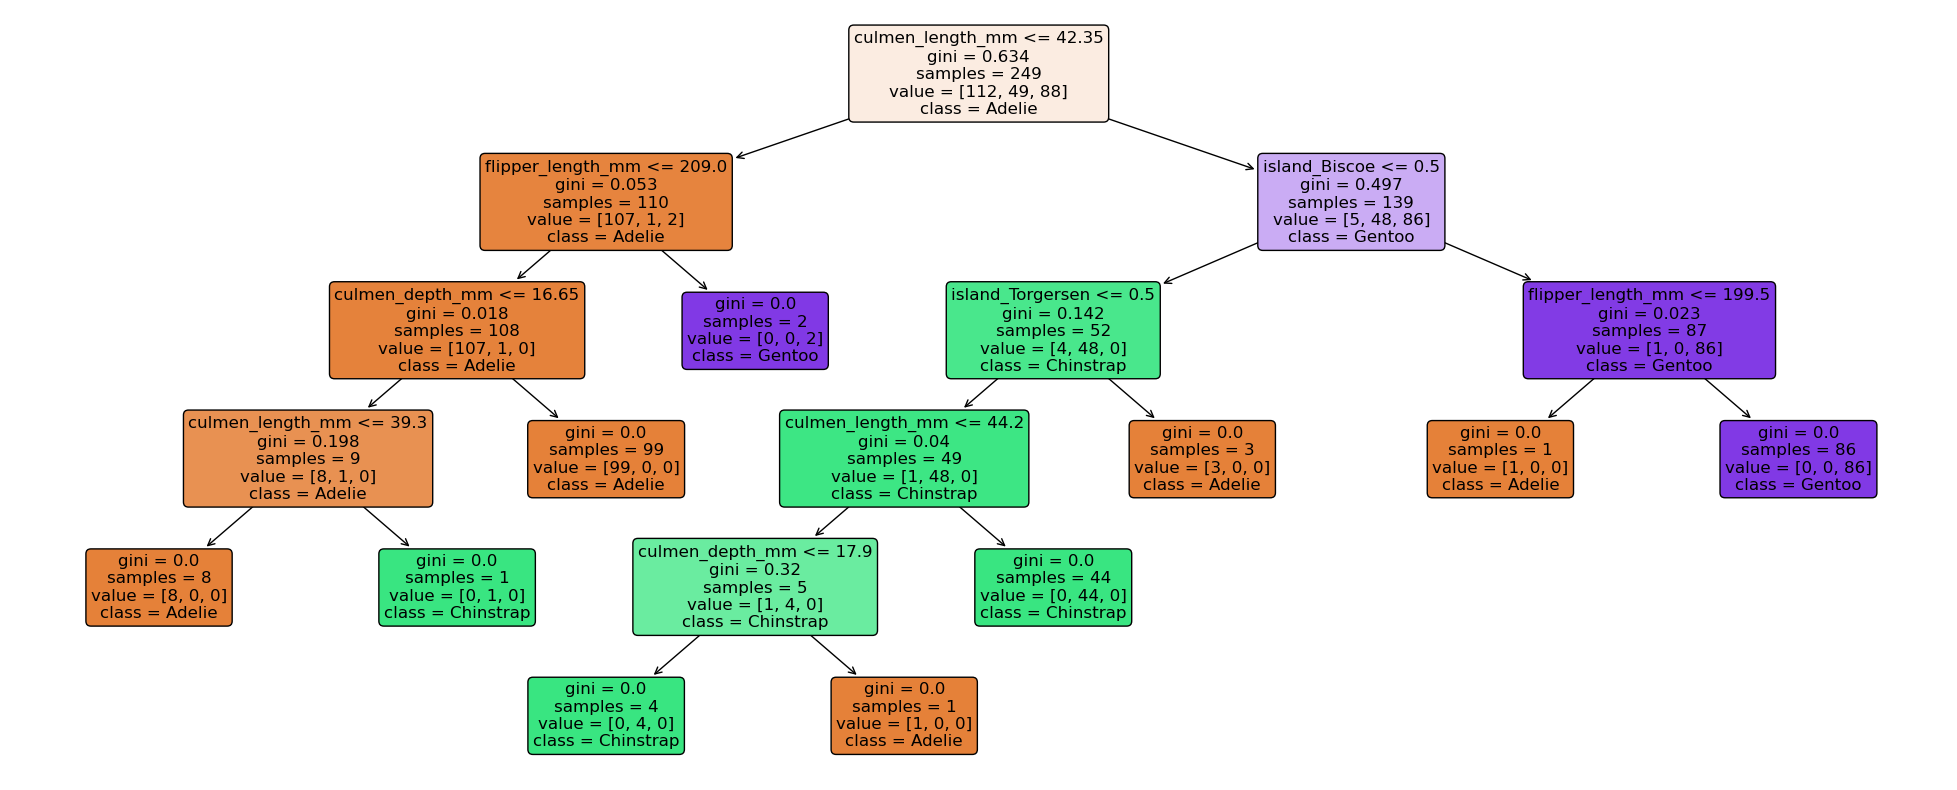

In [8]:
#Top-DT
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, None],  #depth values
    'min_samples_split': [2, 5, 10]  #split values
}
top_dt_classifier = DecisionTreeClassifier()
grid_search = GridSearchCV(top_dt_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_top_dt_classifier = DecisionTreeClassifier(**best_params)
best_top_dt_classifier.fit(X_train, y_train)
plt.figure(figsize=(25, 10))
plot_tree(best_top_dt_classifier, filled=True, feature_names=X.columns, class_names=y.unique(),fontsize=12, rounded=True)
plt.show()
y_pred = best_top_dt_classifier.predict(X_test)

# Append information to the performance file
with open('penguin-performance-Top-DT.txt', 'a') as file:
    file.write("A) \nTop-DT: Decision Tree with GridSearch\n")
    file.write(f"Best Hyperparameters: {best_params}\n\n")
    file.write("-" * 50 + "\n")

    file.write("B)\n")
    file.write("Confusion Matrix:\n")
    file.write(str(confusion_matrix(y_test, y_pred)) + "\n\n")
    file.write("-" * 50 + "\n")

    file.write("C)\n")
    file.write("Classification Report:\n")
    file.write(classification_report(y_test, y_pred) + "\n")
    file.write("-" * 50 + "\n")

    file.write("D)\n")
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    file.write("Accuracy: {:.4f}\n".format(accuracy))
    file.write("Macro-average F1: {:.4f}\n".format(macro_f1))
    file.write("Weighted-average F1: {:.4f}\n".format(weighted_f1))

    file.write("\n" + "*" * 50 + "\n\n")


In [11]:
#Base-MLP
base_mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 100), activation='logistic',solver='sgd')
base_mlp_classifier.fit(X_train, y_train)
y_pred = base_mlp_classifier.predict(X_test)

# Append information to the performance file
with open('penguin-performance-base-mlp.txt', 'a') as file:
    file.write("A)\n")
    file.write("Base-MLP: Multi-Layered Perceptron\n")
    file.write("Hyperparameters:\n")
    file.write("Hidden Layer Sizes: (100, 100)\n")
    file.write("Activation Function: Logistic\n")
    file.write("Solver: Stochastic Gradient Descent (SGD)\n\n")
    file.write("-" * 50 + "\n")

    file.write("B)\n")
    file.write("Confusion Matrix:\n")
    file.write(str(confusion_matrix(y_test, y_pred)) + "\n\n")
    file.write("-" * 50 + "\n")
    
    file.write("C)\n")
    file.write(classification_report(y_test, y_pred, zero_division=1) + "\n")
    file.write("-" * 50 + "\n")
    
    file.write("D)\n")
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    file.write("\nAccuracy: {:.4f}\n".format(accuracy))
    file.write("Macro-average F1: {:.4f}\n".format(macro_f1))
    file.write("Weighted-average F1: {:.4f}\n".format(weighted_f1))

    file.write("\n" + "*" * 50 + "\n\n")
